In [1]:
%load_ext autoreload
%autoreload 2

# Datalink
# https://polybox.ethz.ch/index.php/s/d0FWhtqYRHpSwra?path=%2F

import os
import datetime
import numpy as np 
import matplotlib.pyplot as plt

#os.chdir('../'); print(os.getcwd())
os.chdir('/Users/edouardpaupe/Desktop/magnify-main')
print(os.getcwd())

from src.utils import (
                        get_list_of_buildings,#parses building folder names to create a table of building attributes (type, age, climate, id, folder).
                        load_armax_model,
                        load_weather_data,
                        add_solar_bins,
                        prepare_weather_data,
                        get_weather_forecasts,
                        plot_weather_forecasts,
                        plot_episode
                        )
from src.env import Env
from src.agents import RB, MPC

/Users/edouardpaupe/Desktop/magnify-main


# Get ARX models

In [2]:
models_dir = os.listdir('armax_models/archetypes')
buildings = get_list_of_buildings(models_dir)
buildings


,type,age,climate,id,folder
0,SFH,1,3,451,ep_SFH_age_1_climate_3_451
1,SFH,0,0,821,ep_SFH_age_0_climate_0_821
2,SFH,0,3,1123,ep_SFH_age_0_climate_3_1123
3,SFH,1,2,852,ep_SFH_age_1_climate_2_852
4,SFH,0,2,1691,ep_SFH_age_0_climate_2_1691
5,SFH,1,1,458,ep_SFH_age_1_climate_1_458
6,SFH,0,4,1072,ep_SFH_age_0_climate_4_1072
7,SFH,0,1,535,ep_SFH_age_0_climate_1_535
8,SFH,0,3,955,ep_SFH_age_0_climate_3_955
9,SFH,0,2,1972,ep_SFH_age_0_climate_2_1972


In [3]:
# Example building folder:

# Create the path to a specific building archetype folder
building_folder = os.path.join('armax_models', 'archetypes', 'ep_SFH_age_0_climate_0_1241')  # 'armax_models/archetypes/ep_SFH_age_0_climate_0_649'

# Load the ARMAX model configuration for this building
armax_config = load_armax_model(
    building_folder_path=building_folder,  # path to the building folder
    steps_per_hour=4,                     # time discretization (4 = 15min steps)
)
#load_armax_model returns a dictionary with the ARMAX model configuration

# Select which keys to display from the ARMAX config dictionary
keys_to_show = [
    'dynamics_lags_list',  # list of lag terms for model dynamics
    'feat_length',         # length of feature vector
    'solar_terms',         # number of solar irradiance terms
    'steps_per_hour',      # time discretization
    'n_zones',             # number of zones in the building
    'building_folder',     # folder path for the building
    'model_type'           # type of ARMAX model
]

# Create a dictionary with only the selected keys and their values from armax_config
{key: armax_config[key] for key in keys_to_show}

{'dynamics_lags_list': [1, 2, 4, 8, 32],
 'feat_length': 20,
 'solar_terms': 9,
 'steps_per_hour': 4,
 'n_zones': 5,
 'building_folder': 'armax_models/archetypes/ep_SFH_age_0_climate_0_1241',
 'model_type': 'ARMAX'}

# Get weather scenarios

In [4]:
# Load the climate data
path = os.path.join('armax_models','archetypes', 'meteo', 'pop_weighted')
weather_df = load_weather_data(file_path=path, climate_id=0) #returns a dataframe with weather data (timestamp, T_amb, solar)
#climate_id corresponds to the climate scenario of the building, going from 0 to 5.
# Add solar bins to the weather data
weather_df = add_solar_bins(weather_df, steps_per_hour=armax_config['steps_per_hour'])
#returns the same dataframe with an additional column for solar bins, the solar irradiance is discretized into 9 bins accross the day.
weather_df.head()

,T_amb,irrad,solar_bin_5-7,solar_bin_7-9,solar_bin_9-11,solar_bin_11-13,solar_bin_13-15,solar_bin_15-17,solar_bin_17-19,solar_bin_19-21,solar_bin_21-23
time,,,,,,,,,,,
2020-01-01 00:00:00,-0.469978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:15:00,-0.063042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:30:00,0.343893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:45:00,0.750828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,1.157764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


T_amb shape: (320,)
Q_irr shape: (320, 9)


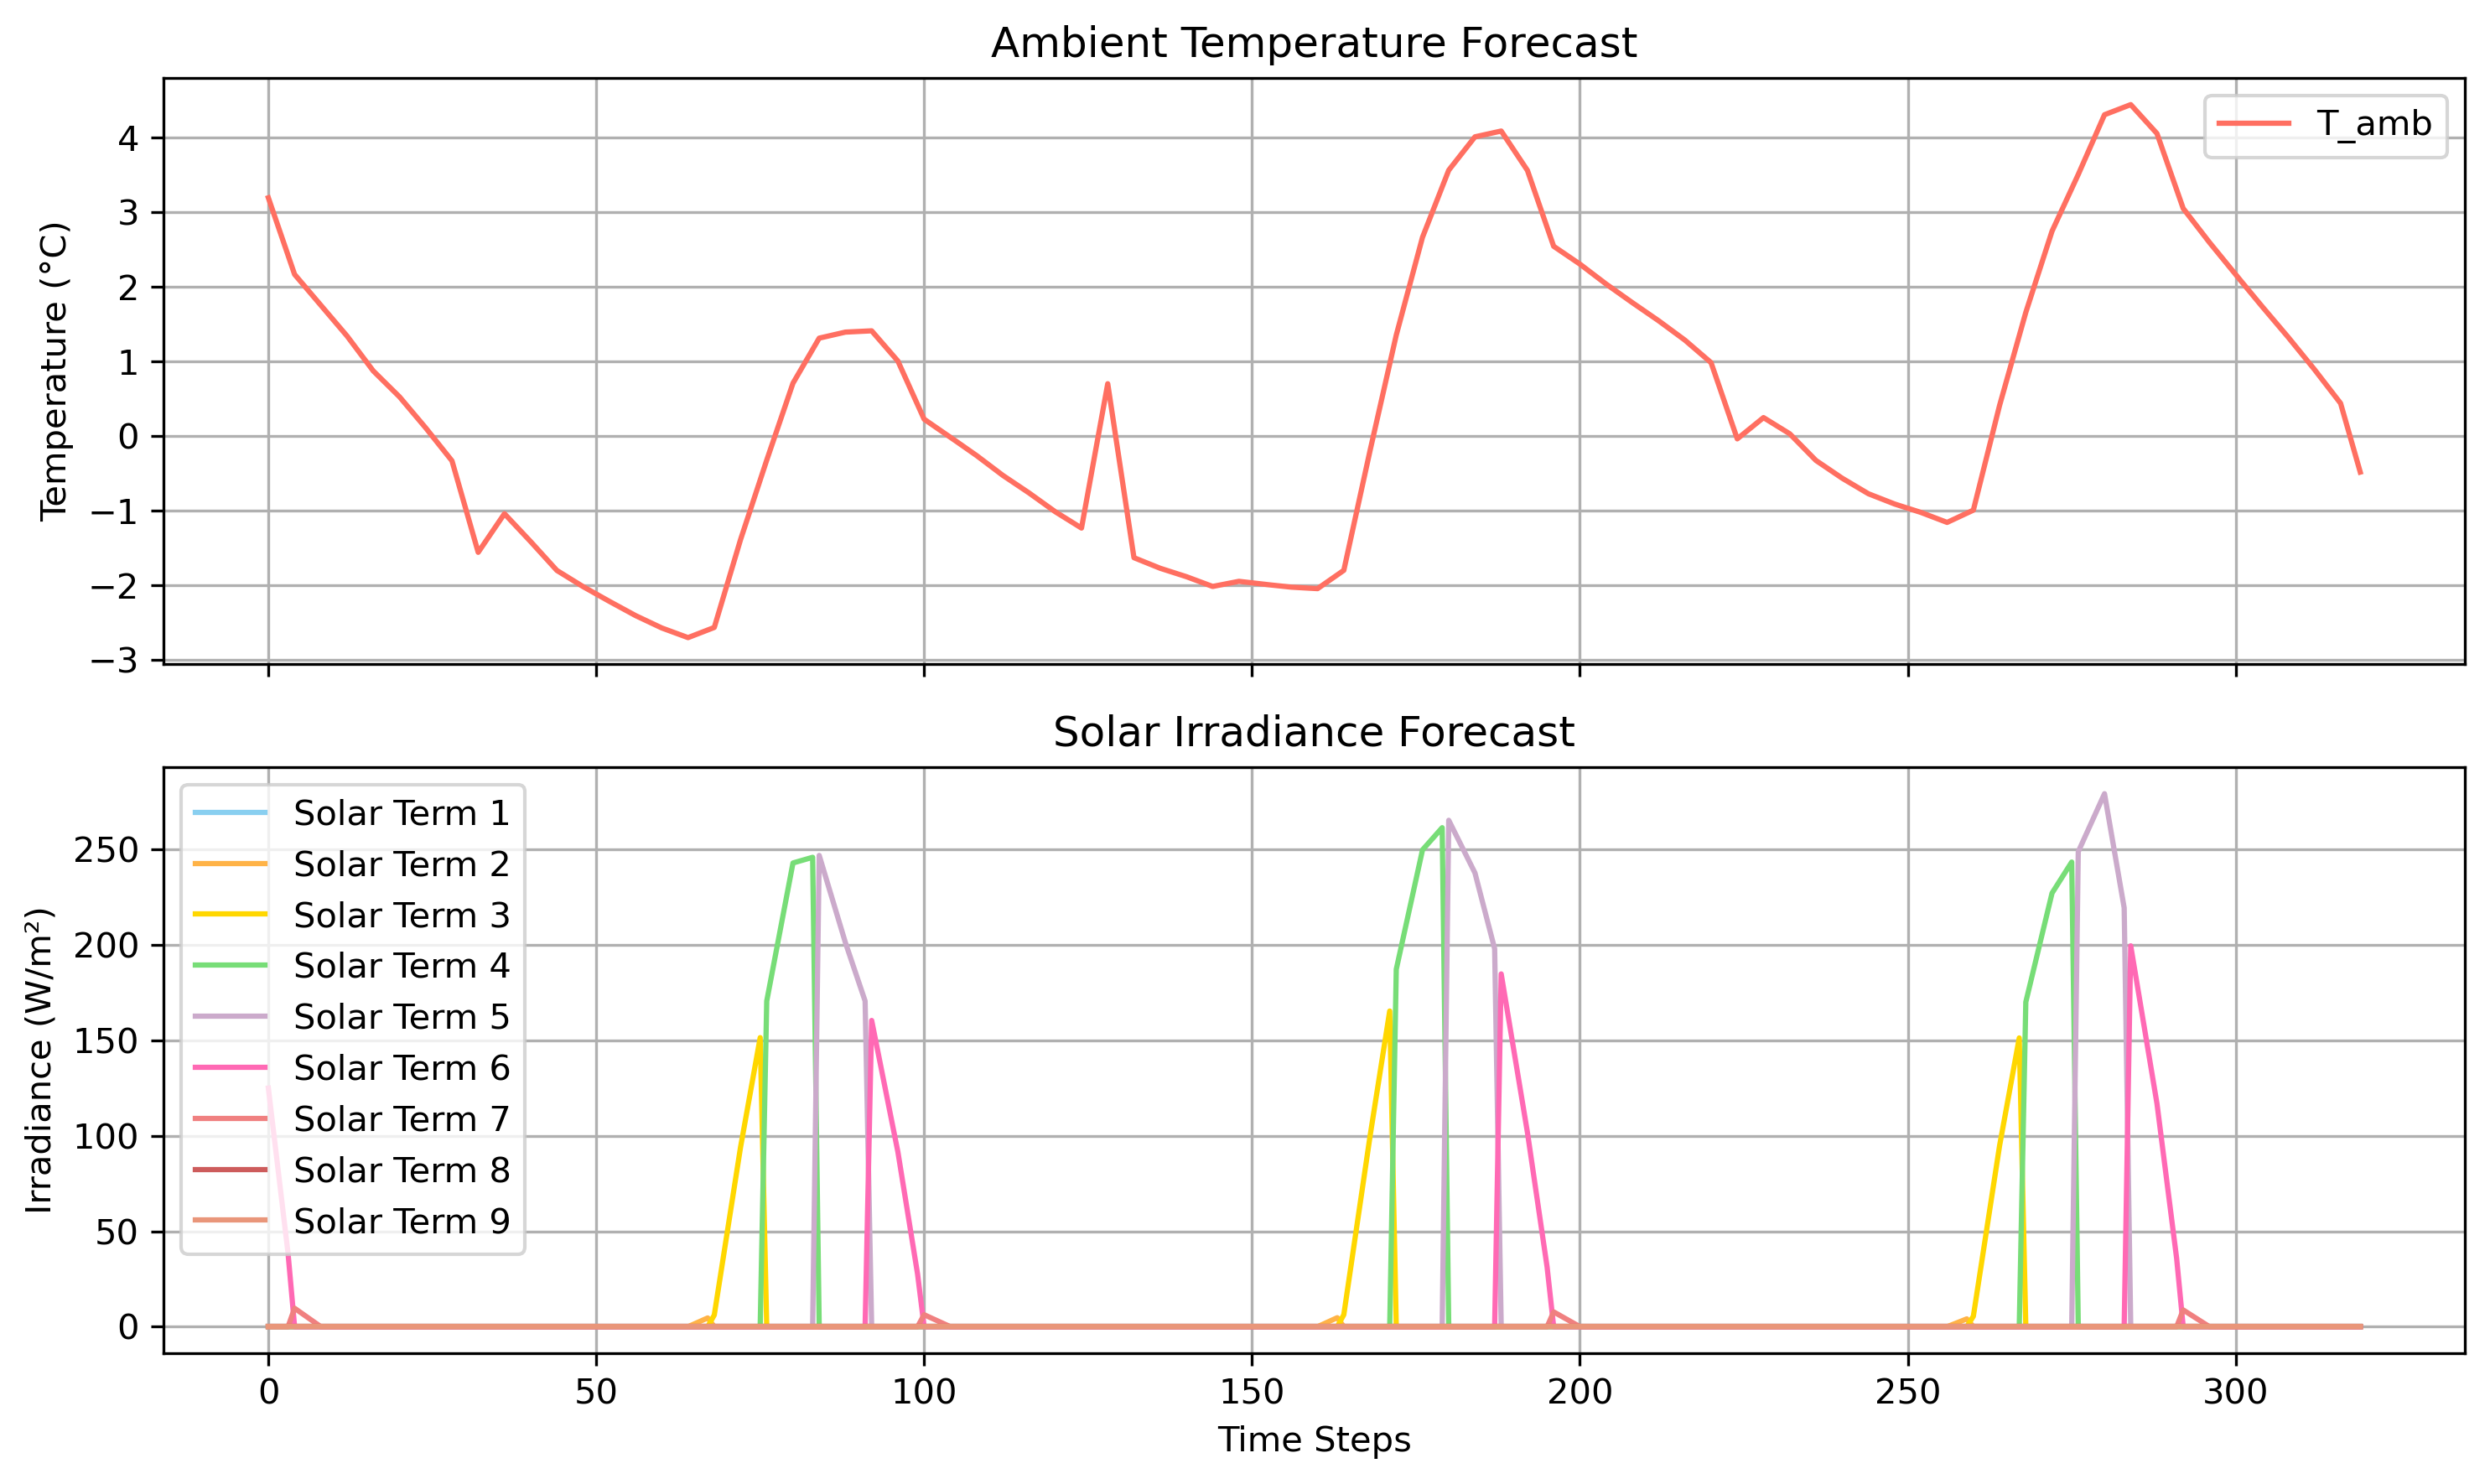

In [5]:
# Get forecasts adapted to the ARMAX model
weather, idx_map, col_map = prepare_weather_data(weather_df)
#returns the weather data as a numpy array, and index/column maps for easy access to specific timestamps and variables.
T_amb, Q_irr = get_weather_forecasts(
        current_time=datetime.datetime(2020, 1, 4, 0, 0, 0),
        array=weather,
        idx_map=idx_map,
        col_map=col_map,
        history_length=4 * 8,  # 8 hours of history at 4 steps per hour
        horizon_length=4 * 24 * 3 # 3 days of forecasts at 4 steps per hour
        
    )

# Print the shapes of the outputs
print(f'T_amb shape: {T_amb.shape}')
print(f'Q_irr shape: {Q_irr.shape}')

# Plot T_amb and Q_irr forecast 
plot_weather_forecasts(T_amb=T_amb, Q_irr=Q_irr)

# Define environment

In [15]:
# Initialize the environment
# Define the environment parameters
#the environment simulates the building dynamics using the ARMAX model, provides the state and reward to the agent, and applies the agent's actions to update the building state.
env = Env(
    building_id='ep_SFH_age_0_climate_0_649',
    climate_id=0,
    start_time=datetime.datetime(2020, 5, 1, 0, 0, 0), #from 8th jan at 00:00 to 10th jan at 00:00-->  hours
    end_time=datetime.datetime(2020, 5, 1, 0, 0, 0), 
    history_hours=8,#how many hours of past data the environment provides to the agent at each step
    horizon_hours=24, #how many hours of future weather forecast the environment provides to the agent at each step
    steps_per_hour=4,#time discretization (4 = 15min steps
)



# Rule-based controller

In [16]:
""" The rule based controller (RB) maintains the zone temperatures within a specified range by turning the heating on or off based on the current temperature readings. When the lower bound is breached, the heating is activated to raise the temperature, and when the upper bound is exceeded, the heating is turned off to prevent overheating. """
# Reset the environment
observations, _ = env.reset()
# Initialize the rule-based controller
controller = RB(
    n_zones=env.n_zones,
    T_min=20.0,  # Minimum temperature for heating
    T_max=22.0   # Maximum temperature for heating
)

# Run episode
while not env.terminated:
    actions = controller.predict(observations)
    observations, reward, _, done, _ = env.step(actions)

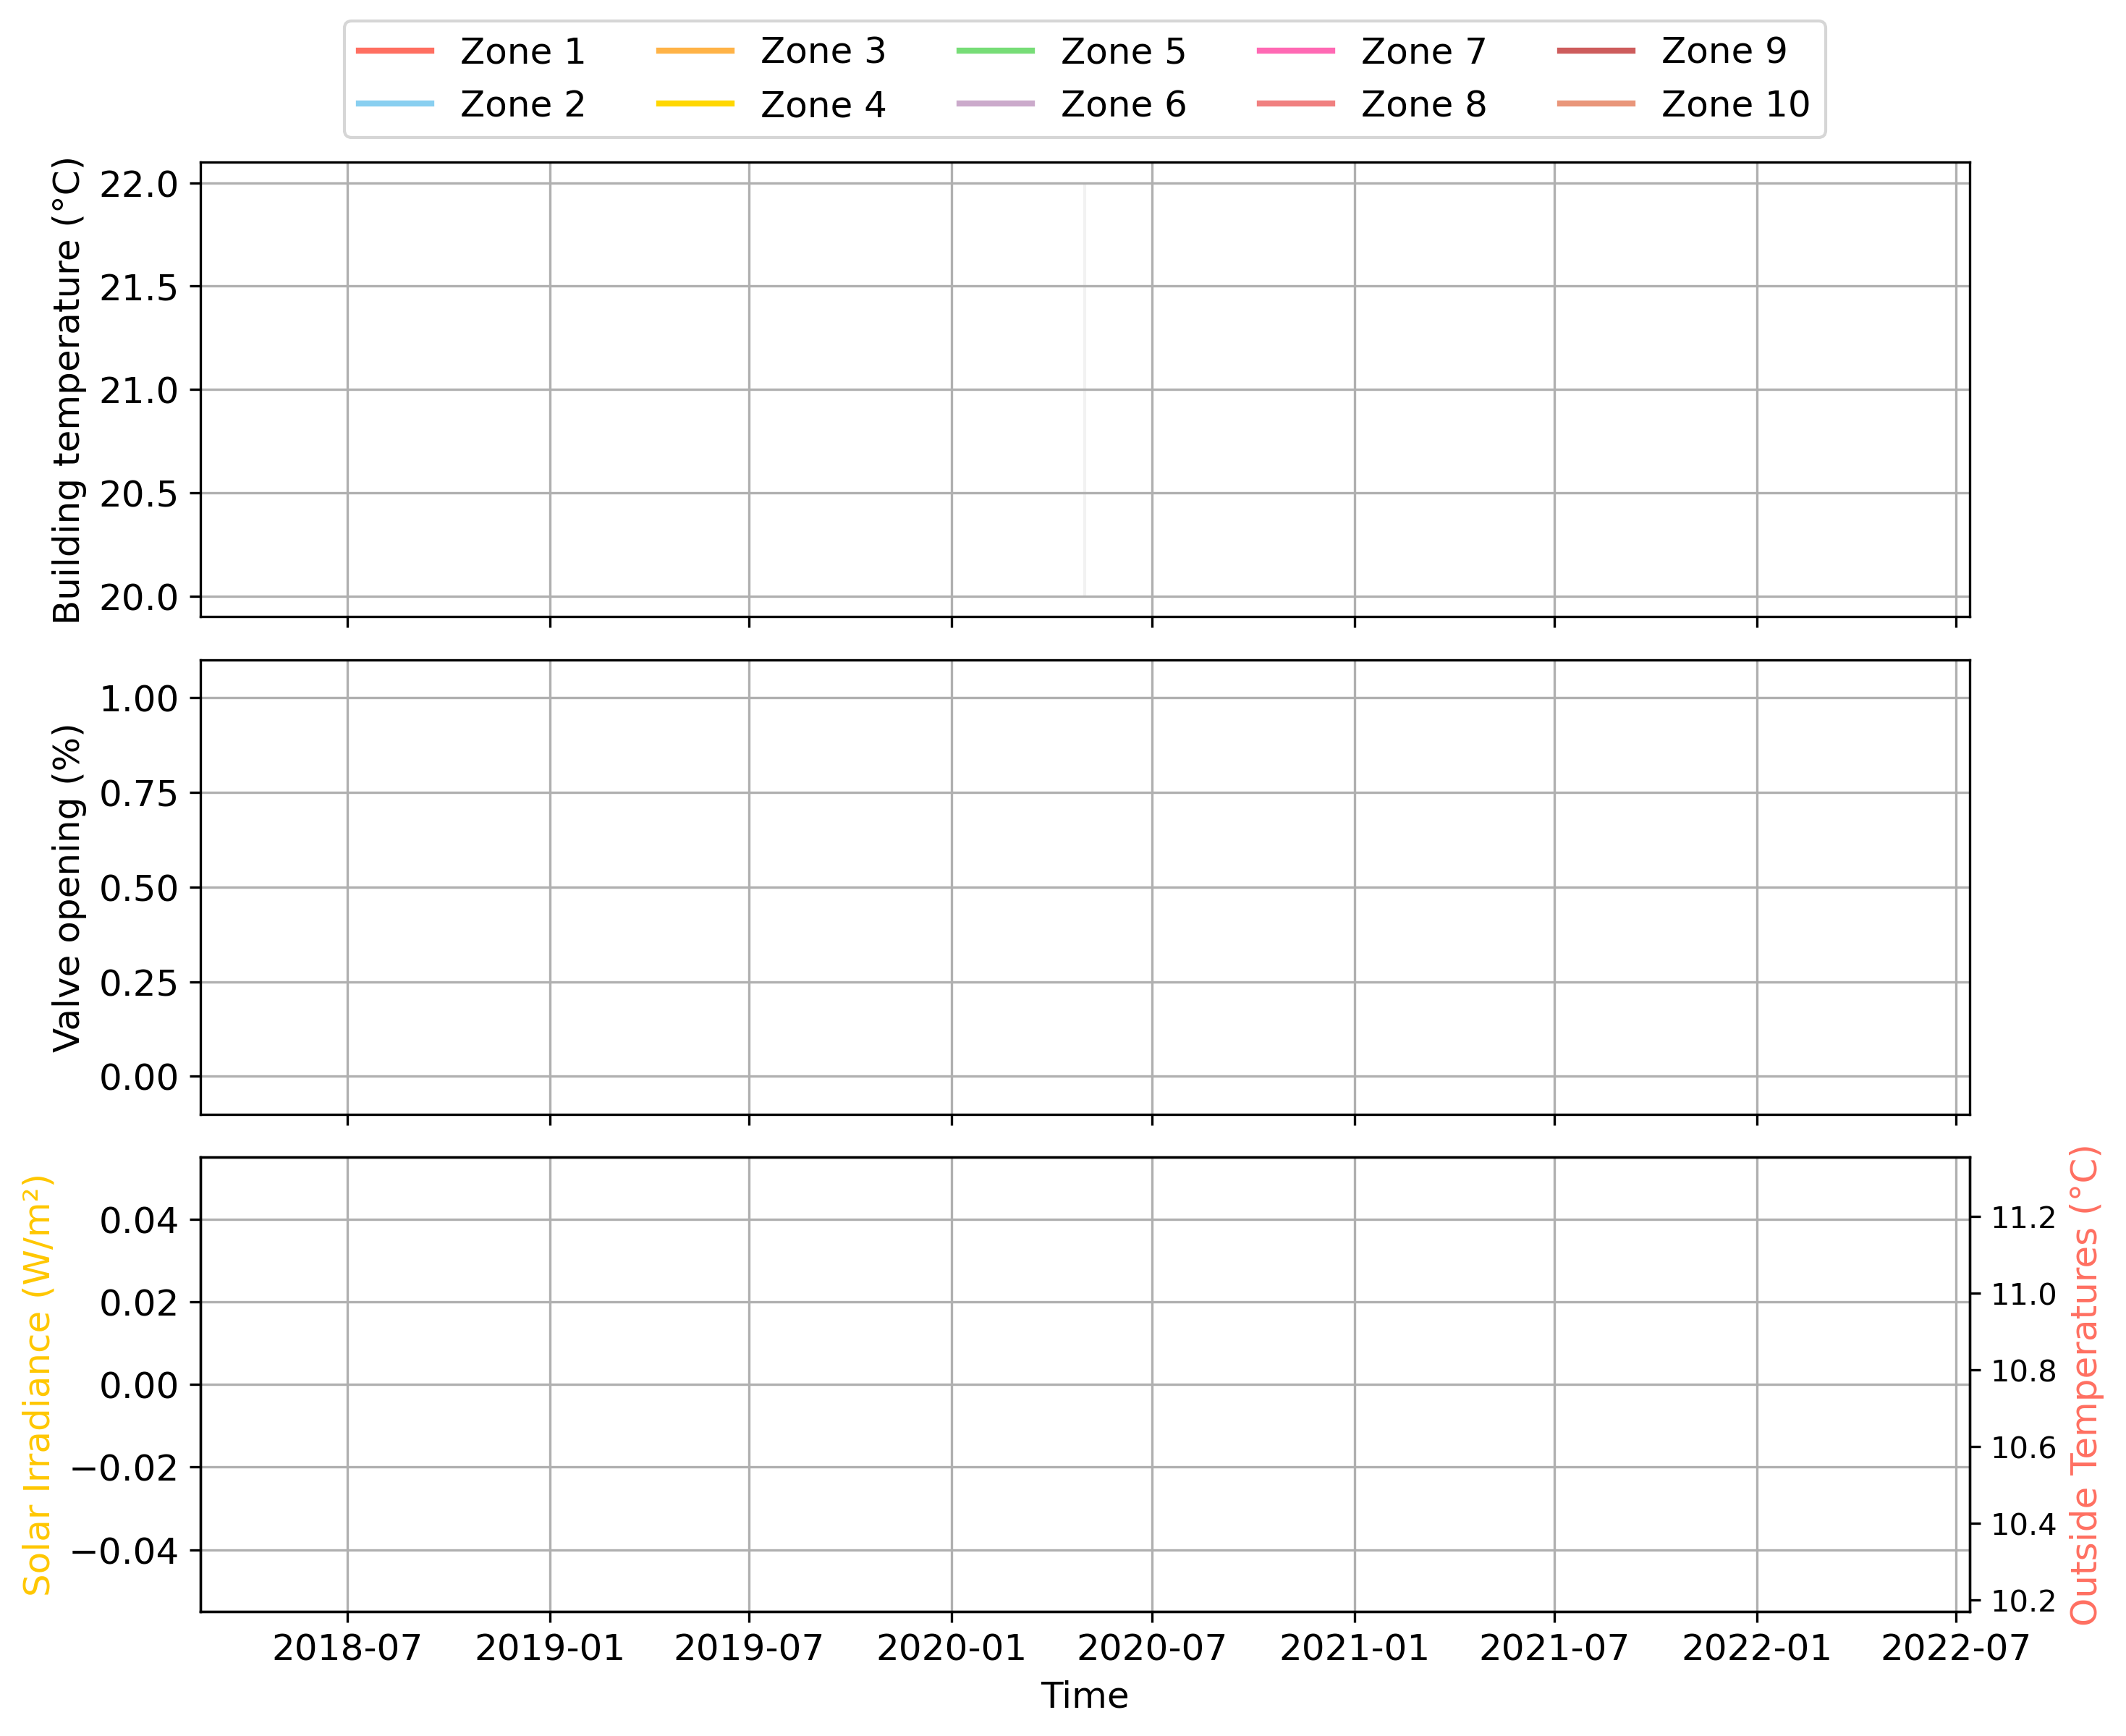

In [17]:
plot_episode(
    timestamps=env.history['timestamp'],
    building_temperature=env.history['temperature'],
    valve_control=env.history['control_action'],
    ambient_temperature=env.history['ambient_temperature'],
    solar_irradiance=env.history['solar_irradiance'],
    T_min=20,
    T_max=22,
)

# MPC

TODO: 
- [ ] Check if time index are correct (noisy ts compared to run_simulation)
- [ ] Enable varying T_min and T_max (e.g. at night). 

In [18]:
controller_config = {
    'target_temperature': 21.0,
    'temperature_bounds': {
            'min': 20.0,
            'max': 22.0
        },
    'history_hours': 8, #how much hours of past data the controller uses to make decisions
    'horizon_hours': 24, #how much hours of future weather forecast the controller uses to make decisions
    'solver': 'gurobi', 
    'solver_options': {'mipgap': 0.01}
}

# Reset the environment
observations, _ = env.reset()
# Initialize the rule-based controller
mpc = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),
    history_length=env.history_length,
    horizon_length=env.horizon_length    
)

# Run episode # (~30 seconds)
while not env.terminated:
    actions = mpc.predict(observations)
    observations, reward, _, done, _ = env.step(actions)

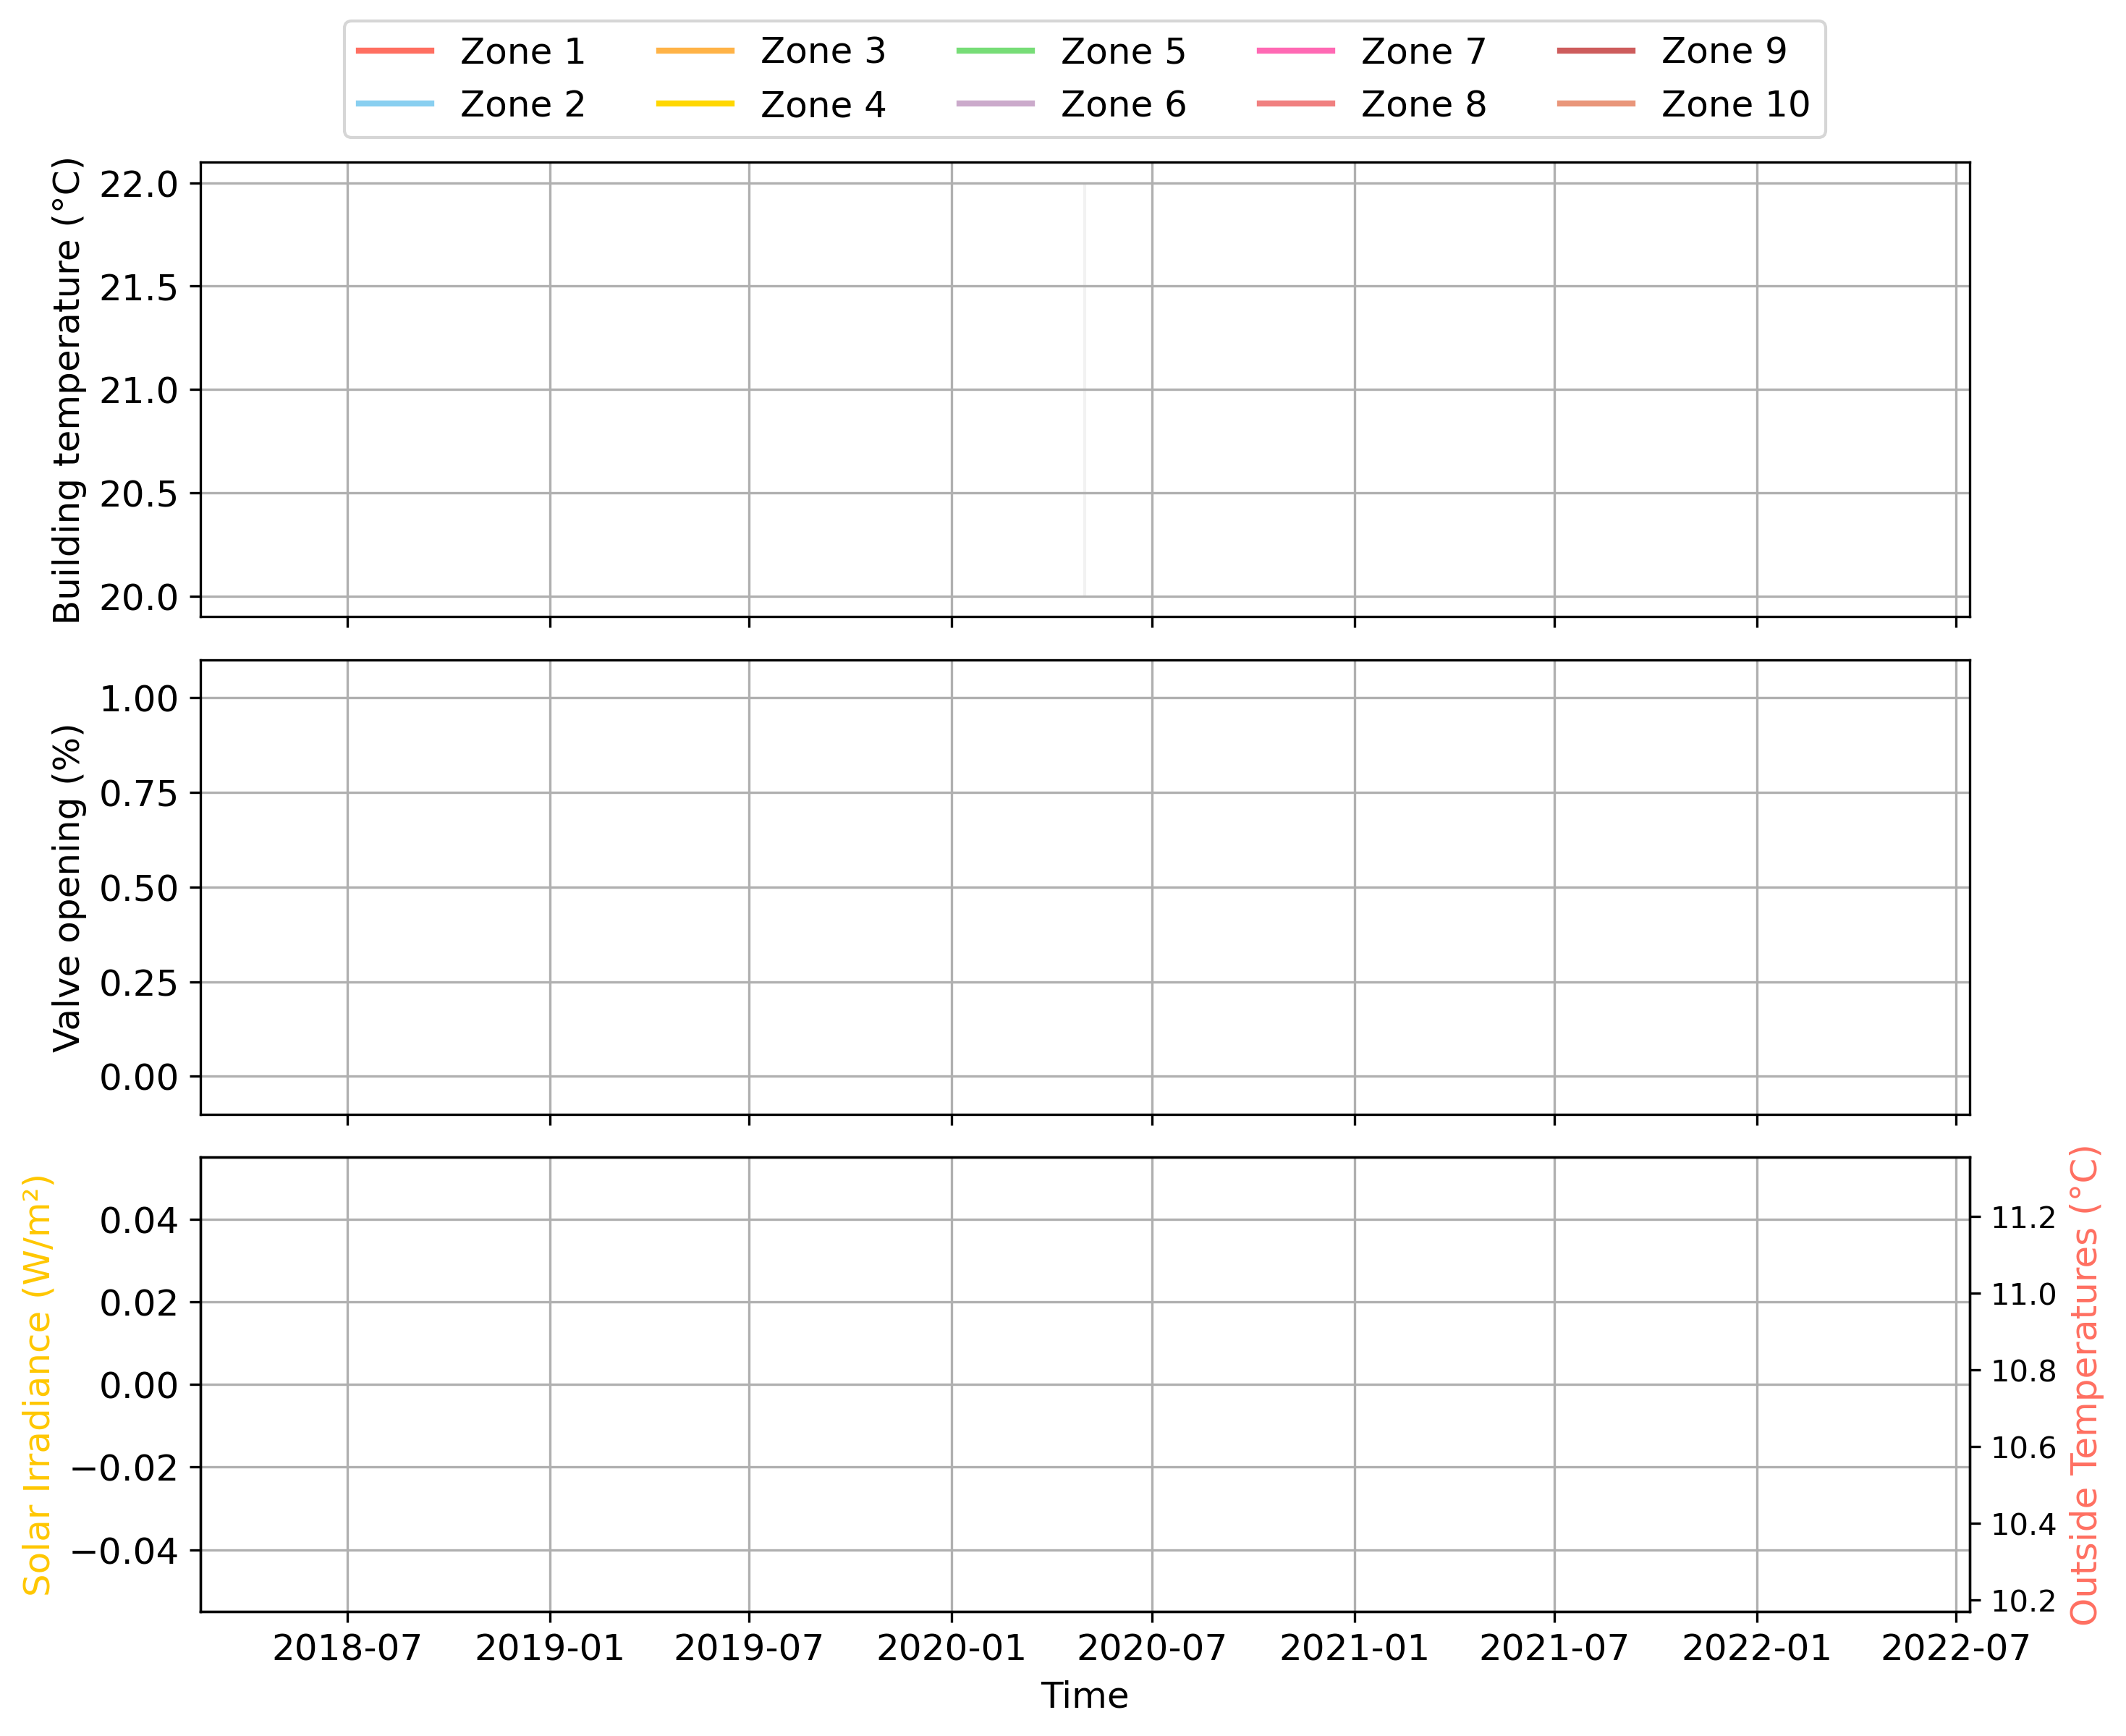

In [19]:
plot_episode(
    timestamps=env.history['timestamp'],
    building_temperature=env.history['temperature'],
    valve_control=env.history['control_action'],
    ambient_temperature=env.history['ambient_temperature'],
    solar_irradiance=env.history['solar_irradiance'],
    T_min=20,
    T_max=22,
)

# Flexibility (with RB controller)

In [6]:
# Initialize the environment for the flexibility computation
env = Env(
    building_id='ep_SFH_age_0_climate_0_1241',  # Select building archetype
    climate_id=0,                               # Climate scenario
    start_time=datetime.datetime(2020, 1, 2, 0, 0, 0),  # Simulation start
    end_time=datetime.datetime(2020, 1, 3, 0, 0, 0),   # Simulation end
    history_hours=8,                            # Past data provided to agent
    horizon_hours=24,                           # Future forecast provided to agent
    steps_per_hour=4,                           # Time discretization (15 min)
)

# Reset the environment to get initial observations
observations, _ = env.reset()

# Initialize the rule-based controller (RB) for comfort control during bounds computation
controller = RB(
    n_zones=env.n_zones,
    T_min=20.0,  # Minimum comfort temperature
    T_max=22.0   # Maximum comfort temperature
)

# Initialize the upper bound MPC controller (maximal heating/flexibility)
upper_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),  # Lower comfort bound
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),# Upper comfort bound
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='upper_bound'  # Objective for upper flexibility bound
)

# Initialize the lower bound MPC controller (minimal heating/flexibility)
lower_bound = MPC(
    armax_config=env.armax_config,
    target_temperature=21.0,
    T_min=np.full((env.horizon_length  + 1, env.n_zones), 20),
    T_max=np.full((env.horizon_length  + 1, env.n_zones), 22.0),
    history_length=env.history_length,
    horizon_length=env.horizon_length,
    objective='lower_bound'  # Objective for lower flexibility bound
)

# Lists to store computation times for each bound
time_upp = []
time_low = []

# Main loop: run until the environment signals termination
while not env.terminated:
    # Compute upper bound (maximal flexibility) and record computation time
    t_upp = datetime.datetime.now()
    upper_bound.predict(observations)
    time_upp.append((datetime.datetime.now() - t_upp).total_seconds())

    # Compute lower bound (minimal flexibility) and record computation time
    t_low = datetime.datetime.now()
    lower_bound.predict(observations)
    time_low.append((datetime.datetime.now() - t_low).total_seconds())

    # Save the results of the current episode for both bounds
    upper_bound.save_episode()
    lower_bound.save_episode()
    
    # Use the rule-based controller to select actions for the next step
    actions = controller.predict(observations)
    obs, reward, _, done, _ = env.step(actions)  # Advance environment

# Print average computation times for upper and lower bound MPCs
print(f'Upper bound computation time: {np.mean(time_upp):.3f} seconds')
print(f'Lower bound computation time: {np.mean(time_low):.3f} seconds')
#print(f"Upper bound computation time: {np.mean(upper_bound.results['solving_time']):.3f} seconds")
#print(f"Lower bound computation time: {np.mean(lower_bound.results['solving_time']):.3f} seconds")

Upper bound computation time: 0.113 seconds
Lower bound computation time: 0.119 seconds


In [ ]:
while not env.terminated:
    #compute flexibility
    batch_flexibility = upper_bound.predict(observations)
    predictive_model.fit(observations, batch_flexibility)
    

(5, 128, 2)
(96, 2)


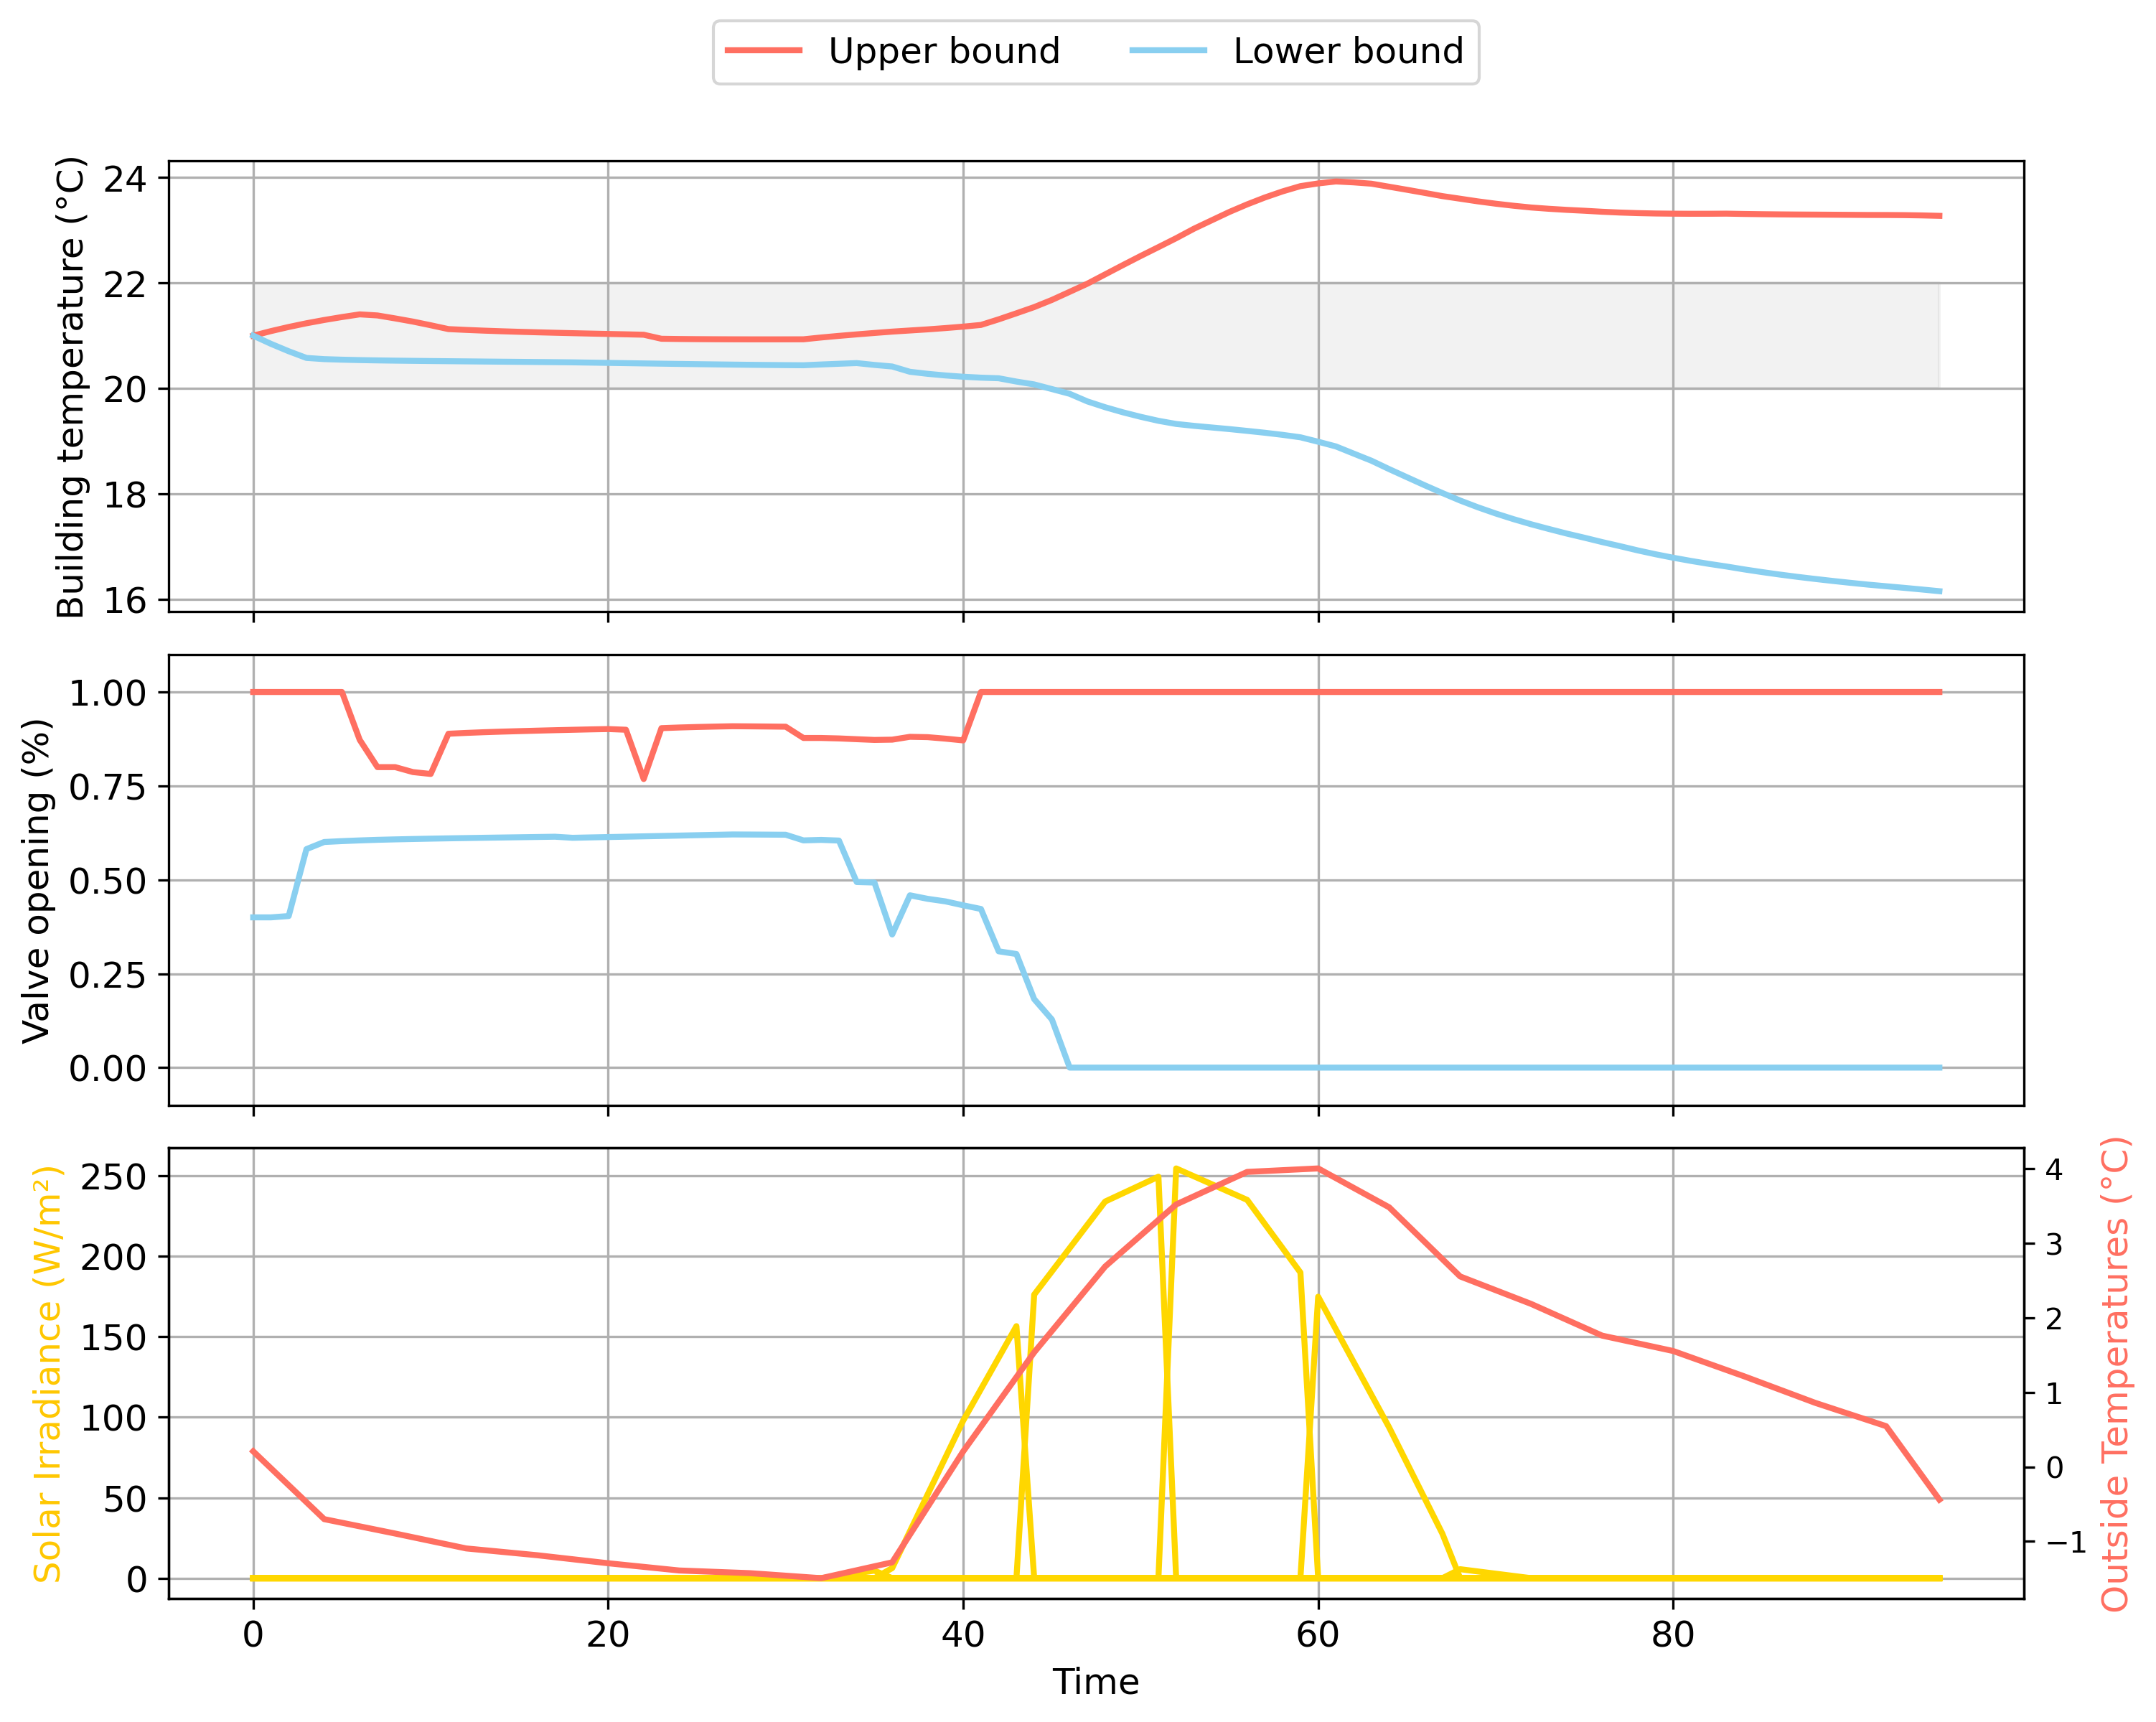

In [7]:
# Average flexibility curves

# def to_array(results: Dict[int, Dict[int, float]], key: str) -> np.ndarray:
#     # list of zones → array of shape (n_zones, n_steps) → transpose → (n_steps, n_zones)
#     zone_dicts = results[key][t]
#     mat = np.array([ list(zone_dict.values()) for zone_dict in zone_dicts.values() ])
#     return mat.T

t = 0 #only plot the first time step

T_bounds = np.transpose([ 
    [list(x.values()) for x in upper_bound.results['temperature'][t].values()],
    [list(x.values()) for x in lower_bound.results['temperature'][t].values()],
])
#u_bounds is a (n_zones, n_steps, 2) array containing the upper and lower control actions (heating valve positions) for each time step and zone
u_bounds = np.transpose([
    [list(x.values()) for x in upper_bound.results['control_action'][t].values()],
    [list(x.values()) for x in lower_bound.results['control_action'][t].values()],
])

print(u_bounds.shape) #(n_zones, n_steps, 2)

#a is a list of ambient temperature values for each time step
a = [x for x in upper_bound.results['ambient_temperature'][t].values()]
#s is a list of solar irradiance values for each time step
s = [list(x.values()) for x in upper_bound.results['solar_irradiance'][t].values()]

building_temperature = np.mean(T_bounds[:, env.history_length:-1, :], axis=0) 
valve_control = np.mean(u_bounds[:, env.history_length:, :], axis=0) #average control action across zones
print(valve_control.shape) #(n_steps, n_zones)
#the valve control represents the average heating valve position across all zones, indicating the overall heating effort applied to maintain comfort levels. it is a value between 0 (valve fully closed, no heating) and 1 (valve fully open, maximum heating).
#to go from valve position to power, multiply by the max power of the heating system (in kW)

plot_episode(
    #  Plots the average temperature and control action curves for all zones, comparing upper and lower bound MPC results over the prediction horizon.
    timestamps=range(env.horizon_length),
    building_temperature=np.mean(T_bounds[:,env.history_length:-1,:], axis=0), # Exclude the last time step
    valve_control=np.mean(u_bounds[:,env.history_length:,:], axis=0),
    ambient_temperature=a[env.history_length:],
    solar_irradiance=s[env.history_length:],
    T_min=20,
    T_max=22,
    labels=['Upper bound', 'Lower bound']
)


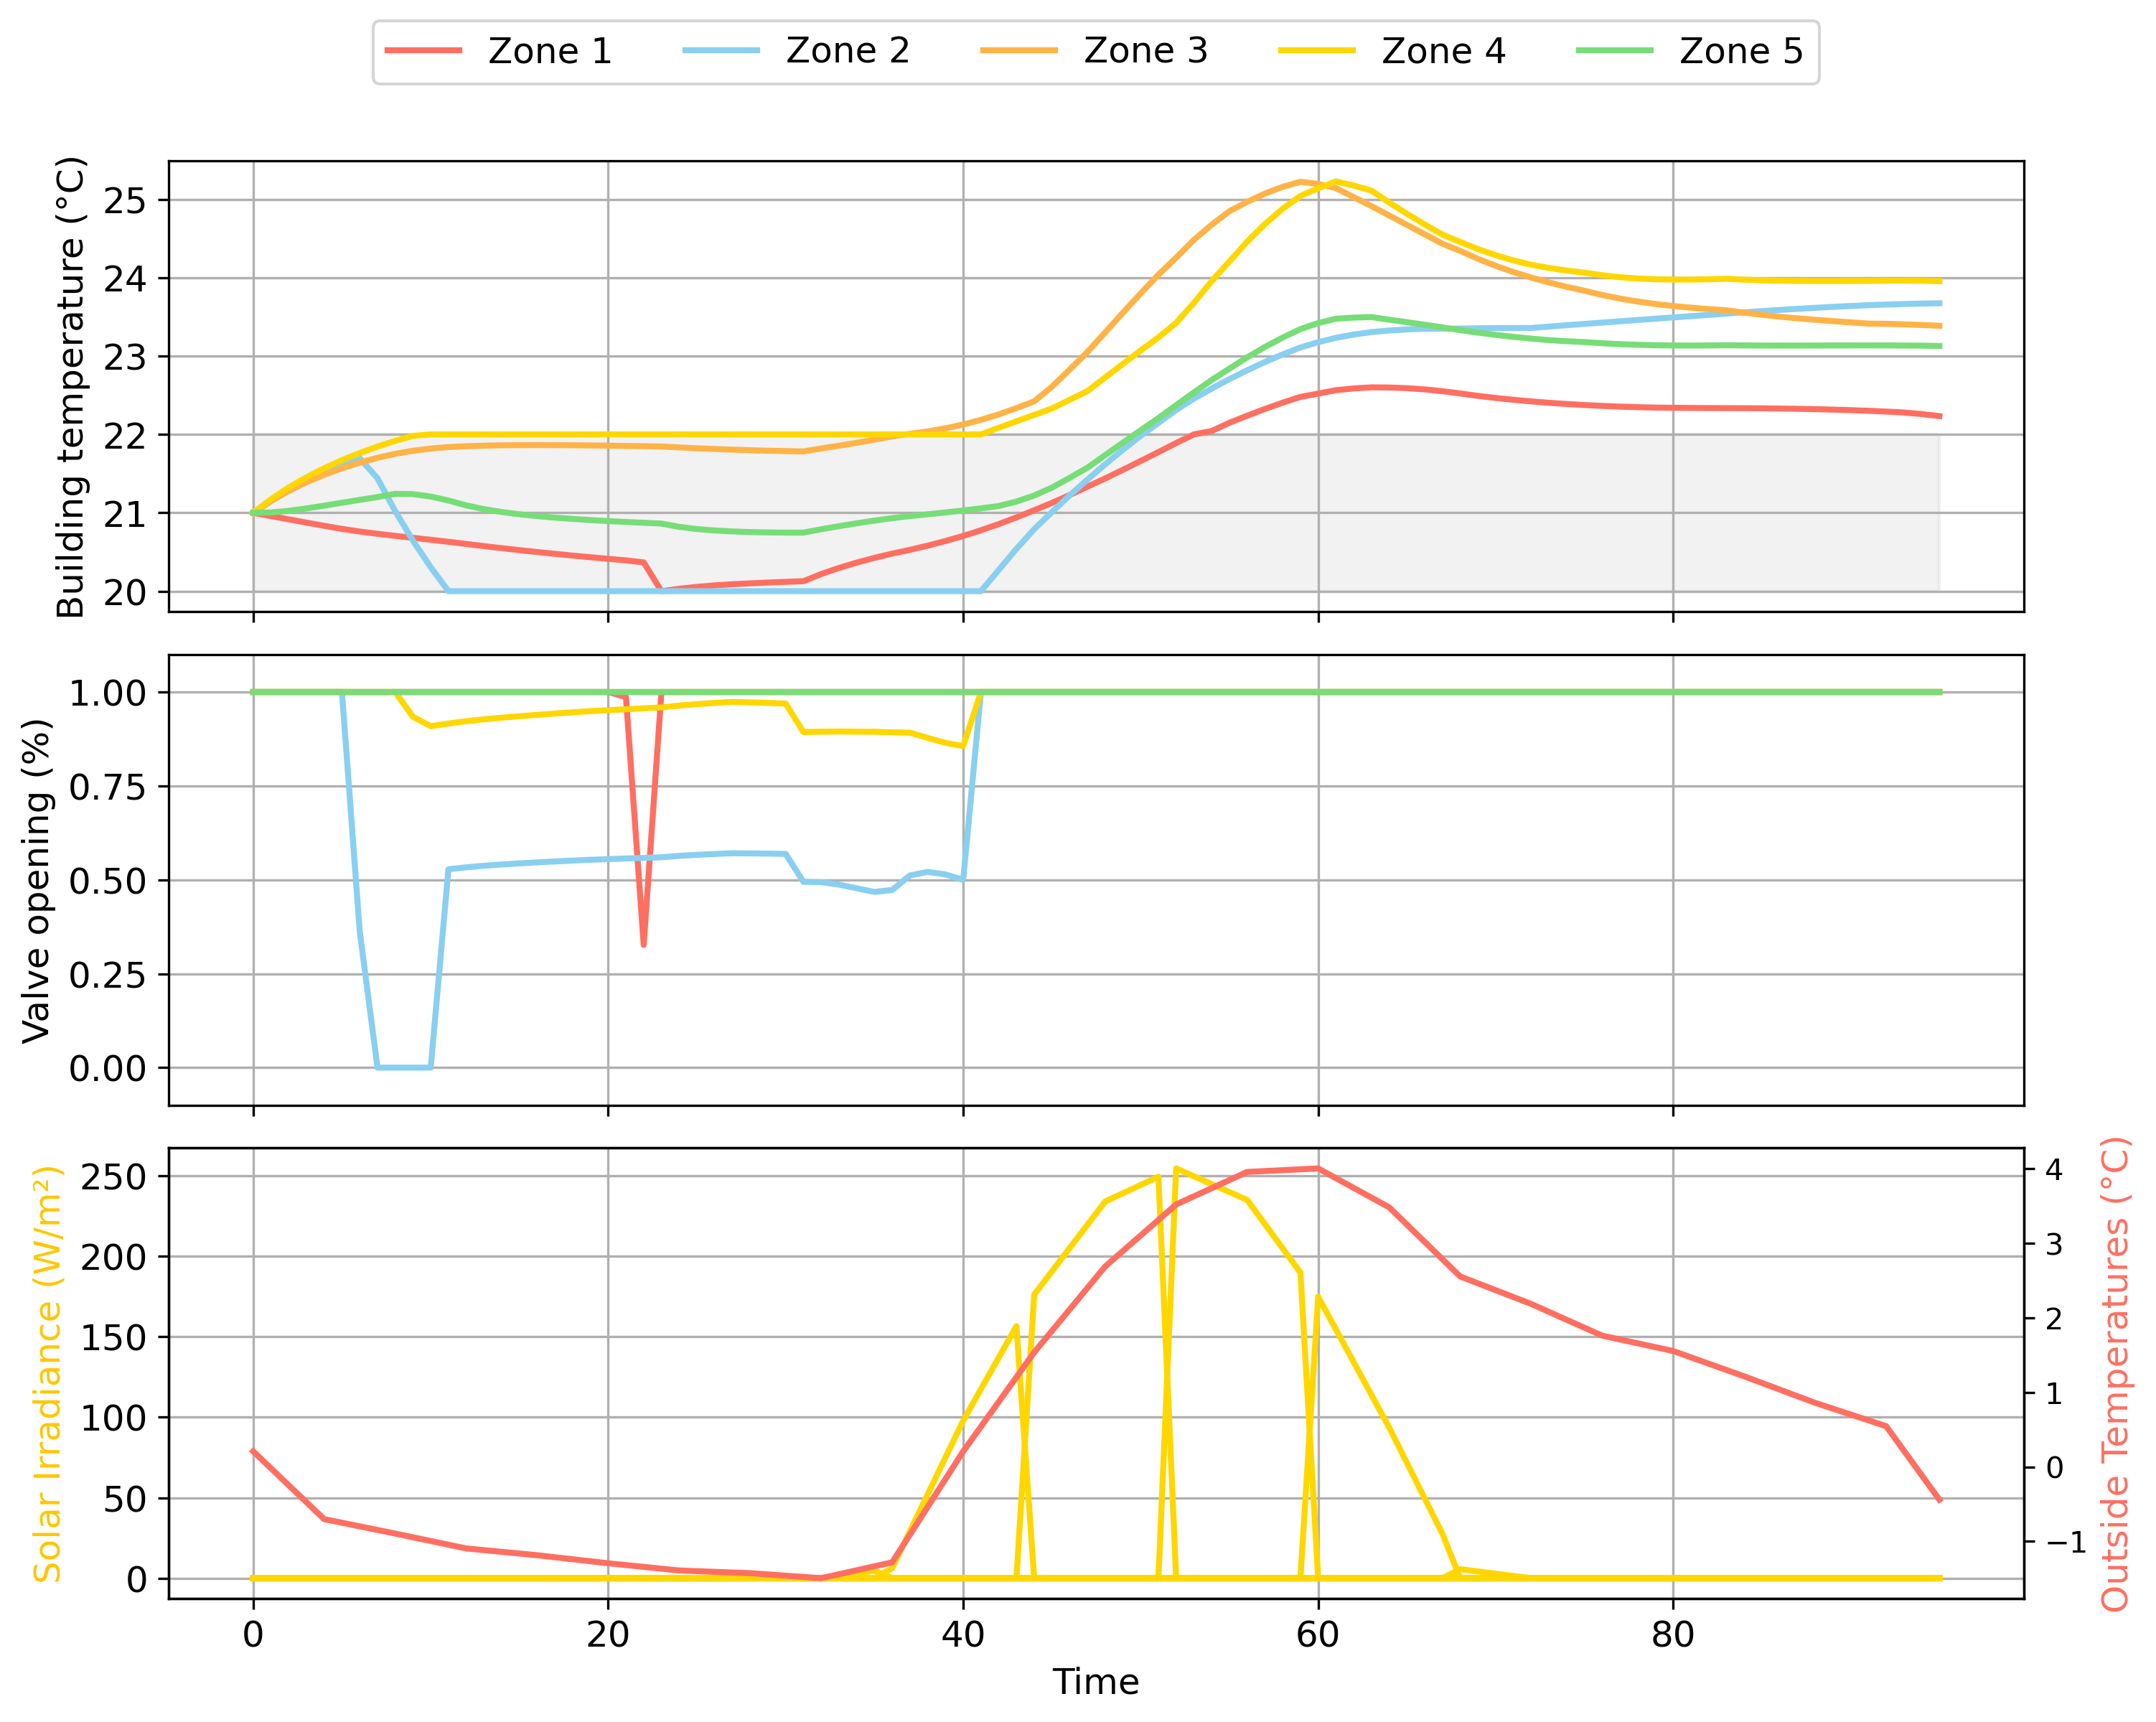

In [8]:
# Upper bounds
plot_episode(
    timestamps=range(env.horizon_length),
    building_temperature=T_bounds[:,env.history_length:-1,0].T,
    valve_control=u_bounds[:,env.history_length:,0].T,
    ambient_temperature=a[env.history_length:],
    solar_irradiance=s[env.history_length:],
    T_min=20,
    T_max=22,
)

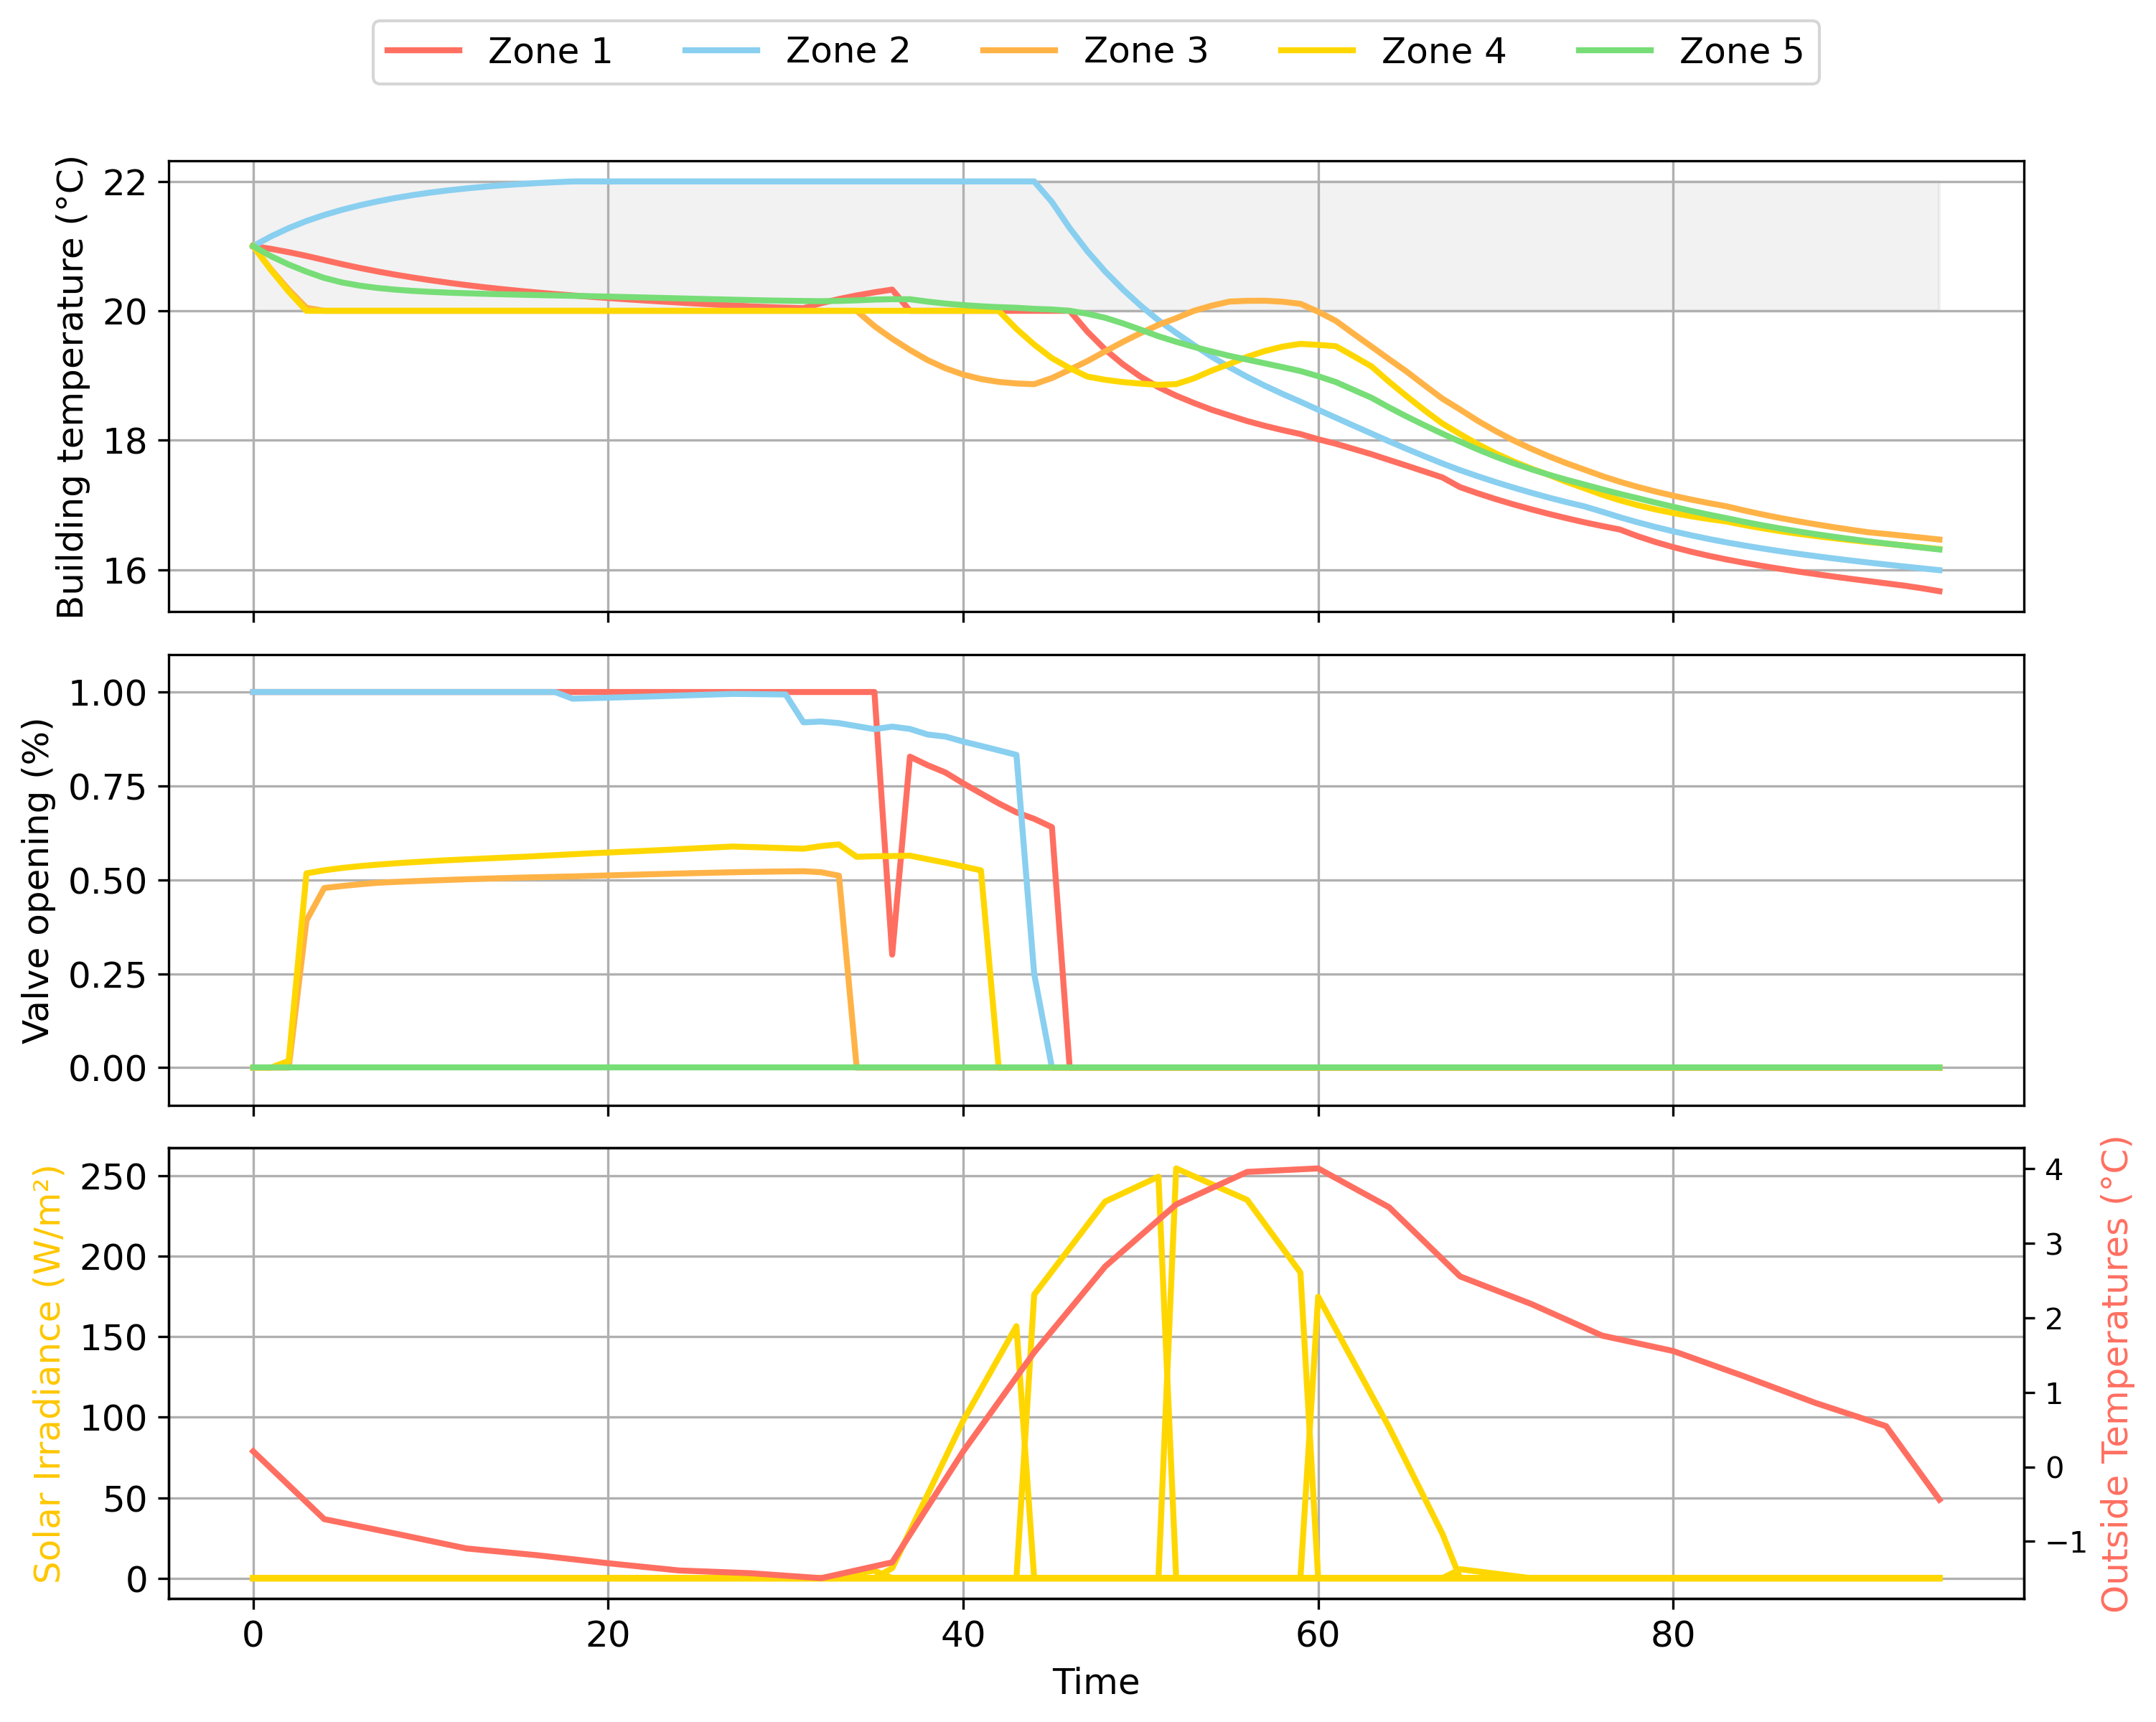

In [9]:
#lower bounds
plot_episode(
    timestamps=range(env.horizon_length),
    building_temperature=T_bounds[:,env.history_length:-1,1].T,
    valve_control=u_bounds[:,env.history_length:,1].T,
    ambient_temperature=a[env.history_length:],
    solar_irradiance=s[env.history_length:],
    T_min=20,
    T_max=22,
)

In [ ]:
# Next:
# - Combine several buildings into a single environment (opt. n flexibility curves)
# - Generate batch of flexibility curves (from n buildings)
